In [ ]:
# --- The Final "Super-Patch" Script (Fixes the Index) ---

import pandas as pd
from google.colab import drive
import os
import glob
from tqdm.notebook import tqdm

# --- Setup ---
drive.mount('/content/drive')
DRIVE_PROJECT_ROOT = '/content/drive/MyDrive/VitalDB_Drift_Focused_Dataset'
BATCH_DIR_PATH = os.path.join(DRIVE_PROJECT_ROOT, 'preprocessed_batches')

print(f"--- Starting Final Index Patch for files in: {BATCH_DIR_PATH} ---")

batch_files = glob.glob(os.path.join(BATCH_DIR_PATH, 'batch_*.parquet'))
print(f"Found {len(batch_files)} batch files to patch.")

if not batch_files:
    print("No files found. Exiting.")
else:
    for file_path in tqdm(batch_files, desc="Patching Files"):
        try:
            # Read one batch file
            df = pd.read_parquet(file_path)

            # --- THE DEFINITIVE FIX ---
            # Set a globally unique MultiIndex. This is the correct structure for this data.
            # This solves the root cause of all subsequent shuffle and reindex errors.
            df.set_index(['patient_id', 'Time'], inplace=True)

            # Overwrite the original file with the correctly indexed version
            df.to_parquet(file_path, engine='pyarrow')

        except Exception as e:
            print(f"\nERROR patching file {os.path.basename(file_path)}: {e}")

    print("\n--- Index Patching Complete ---")
    print("All existing batch files now have a unique and meaningful index.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--- Starting Final Index Patch for files in: /content/drive/MyDrive/VitalDB_Drift_Focused_Dataset/preprocessed_batches ---
Found 31 batch files to patch.


Patching Files:   0%|          | 0/31 [00:00<?, ?it/s]


--- Index Patching Complete ---
All existing batch files now have a unique and meaningful index.


--- Libraries installed ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--- Loading data from: /content/drive/MyDrive/VitalDB_Drift_Focused_Dataset/preprocessed_batches ---
Found 31 batch files.

--- Getting unique patient IDs robustly... ---


Reading Patient IDs:   0%|          | 0/31 [00:00<?, ?it/s]

Found 2708 unique patients.

--- Starting Incremental Training... ---


Training on Batches:   0%|          | 0/31 [00:00<?, ?it/s]

--- Incremental training complete. ---
Final model saved to /content/drive/MyDrive/VitalDB_Drift_Focused_Dataset/final_lgbm_model.joblib

--- Predicting on Validation Set... ---


Predicting on Batches:   0%|          | 0/31 [00:00<?, ?it/s]


Validation MAE on 30s Drift: 3.1021
Validation R² on 30s Drift: 0.1595

--- Top 20 Most Important Features ---
BIS/BIS                   1544
Orchestra/PPF20_VOL       1310
Solar8000/HR_mean_300s     891
BIS/EMG_mean_300s          879
BIS/BIS_lag_60s            604
Solar8000/ART_MBP          573
Solar8000/RR_CO2           536
Reversion_Pressure         487
Solar8000/HR_std_300s      468
BIS/BIS_lag_10s            462
BIS/SEF                    403
BIS/SEF_lag_10s            393
BIS/BIS_lag_300s           385
BIS/BIS_lag_600s           383
Solar8000/HR               333
BIS/SEF_lag_600s           322
BIS/SEF_lag_60s            316
BIS/SR                     313
BIS/EMG_std_300s           293
BIS/SEF_lag_300s           278
dtype: int32


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
INFO:distributed.core:Event loop was unresponsive in Scheduler for 15.08s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Scheduler for 15.08s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Scheduler for 15.08s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Scheduler for 15.08s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can c

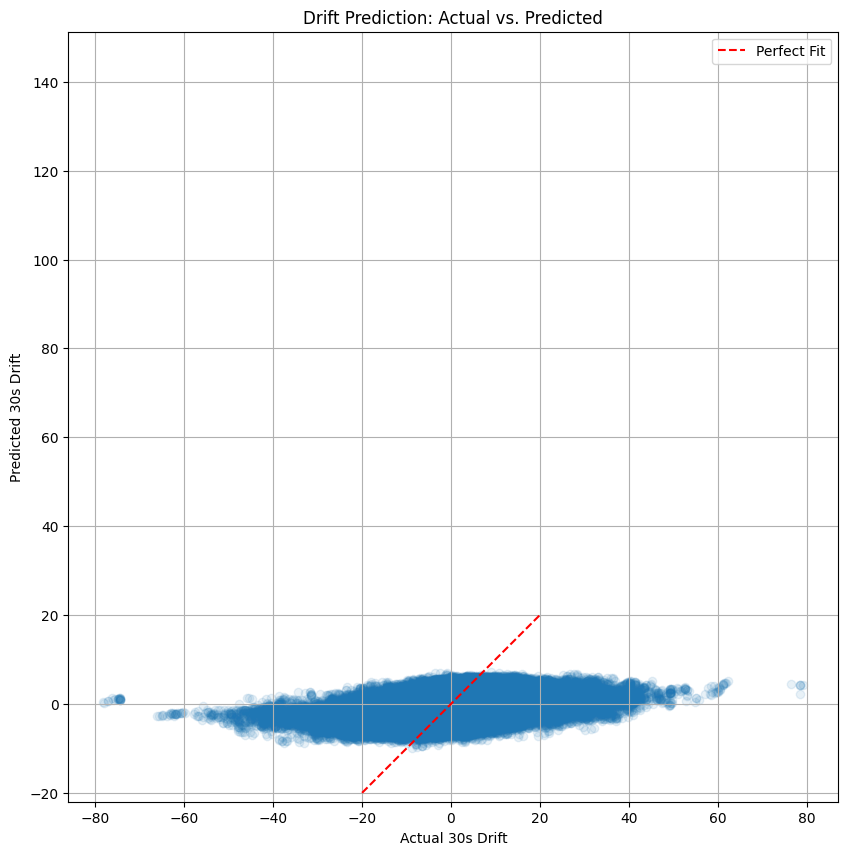

In [ ]:
# --- The Final, Warning-Free LightGBM Training Script ---

# Step 1: Install necessary libraries
!pip install lightgbm pandas numpy scikit-learn matplotlib seaborn google-colab --quiet
print("--- Libraries installed ---")

import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import os
import glob
from tqdm.notebook import tqdm
import joblib
import warnings

# Suppress the warning, as we are now handling it correctly
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=UserWarning, module='lightgbm')


# --- 1. Setup and Get Patient IDs ---
drive.mount('/content/drive')
DRIVE_PROJECT_ROOT = '/content/drive/MyDrive/VitalDB_Drift_Focused_Dataset'
BATCH_DIR_PATH = os.path.join(DRIVE_PROJECT_ROOT, 'preprocessed_batches')
MODEL_SAVE_PATH = os.path.join(DRIVE_PROJECT_ROOT, 'final_lgbm_model.joblib')

print(f"--- Loading data from: {BATCH_DIR_PATH} ---")
batch_files = glob.glob(os.path.join(BATCH_DIR_PATH, 'batch_*.parquet'))
if not batch_files:
    raise FileNotFoundError("No batch files found.")
print(f"Found {len(batch_files)} batch files.")

print("\n--- Getting unique patient IDs robustly... ---")
all_patient_ids = []
for file_path in tqdm(batch_files, desc="Reading Patient IDs"):
    df_temp = pd.read_parquet(file_path)
    all_patient_ids.extend(df_temp.index.get_level_values('patient_id').unique())
patient_ids = np.unique(all_patient_ids)
print(f"Found {len(patient_ids)} unique patients.")

# --- 2. Patient-Aware Train/Validation Split ---
train_ids, val_ids = train_test_split(patient_ids, test_size=0.2, random_state=42)
train_ids_set = set(train_ids)
val_ids_set = set(val_ids)

# --- 3. Incremental Training ---
print("\n--- Starting Incremental Training... ---")
booster = None

for i, file_path in enumerate(tqdm(batch_files, desc="Training on Batches")):
    df_chunk = pd.read_parquet(file_path).reset_index()

    # --- THE FIX: Explicitly create a copy to avoid warnings ---
    train_chunk = df_chunk[df_chunk['patient_id'].isin(train_ids_set)].copy()
    if train_chunk.empty:
        continue

    # Engineer target variable for this chunk
    train_chunk['BIS_future_30s'] = train_chunk.groupby('patient_id')['BIS/BIS'].shift(-30)
    train_chunk['BIS_drift_30s'] = train_chunk['BIS_future_30s'] - train_chunk['BIS/BIS']
    train_chunk.dropna(subset=['BIS_drift_30s'], inplace=True)

    y_train_chunk = train_chunk['BIS_drift_30s']
    X_train_chunk = train_chunk.drop(columns=['BIS_drift_30s', 'BIS_future_30s', 'Time', 'patient_id'])

    # Train on the chunk, continuing from the previous model state
    booster = lgb.train(
        params={'objective': 'regression_l1', 'learning_rate': 0.05, 'num_leaves': 41, 'seed': 42, 'n_jobs': -1, 'verbose': -1},
        train_set=lgb.Dataset(X_train_chunk, label=y_train_chunk),
        num_boost_round=10,
        init_model=booster
    )

print("--- Incremental training complete. ---")
joblib.dump(booster, MODEL_SAVE_PATH)
print(f"Final model saved to {MODEL_SAVE_PATH}")

# --- 4. Prediction on Validation Set ---
print("\n--- Predicting on Validation Set... ---")
all_val_preds = []
all_y_val = []

for file_path in tqdm(batch_files, desc="Predicting on Batches"):
    df_chunk = pd.read_parquet(file_path).reset_index()

    # --- THE FIX: Explicitly create a copy here as well ---
    val_chunk = df_chunk[df_chunk['patient_id'].isin(val_ids_set)].copy()
    if val_chunk.empty:
        continue

    # Engineer target variable for this chunk
    val_chunk['BIS_future_30s'] = val_chunk.groupby('patient_id')['BIS/BIS'].shift(-30)
    val_chunk['BIS_drift_30s'] = val_chunk['BIS_future_30s'] - val_chunk['BIS/BIS']
    val_chunk.dropna(subset=['BIS_drift_30s'], inplace=True)

    y_val_chunk = val_chunk['BIS_drift_30s']
    X_val_chunk = val_chunk.drop(columns=['BIS_drift_30s', 'BIS_future_30s', 'Time', 'patient_id'])

    # Predict on the chunk
    preds = booster.predict(X_val_chunk)
    all_val_preds.append(preds)
    all_y_val.append(y_val_chunk)

# Concatenate all results
y_val_computed = pd.concat(all_y_val)
val_preds_drift_computed = np.concatenate(all_val_preds)

# --- 5. Final Evaluation ---
mae = mean_absolute_error(y_val_computed, val_preds_drift_computed)
r2 = r2_score(y_val_computed, val_preds_drift_computed)
print(f"\nValidation MAE on 30s Drift: {mae:.4f}")
print(f"Validation R² on 30s Drift: {r2:.4f}")

print("\n--- Top 20 Most Important Features ---")
feature_importances = pd.Series(booster.feature_importance(), index=booster.feature_name())
print(feature_importances.sort_values(ascending=False).head(20))

plt.figure(figsize=(10, 10))
plt.scatter(y_val_computed, val_preds_drift_computed, alpha=0.1)
plt.plot([-20, 20], [-20, 20], 'r--', label='Perfect Fit')
plt.xlabel('Actual 30s Drift'); plt.ylabel('Predicted 30s Drift')
plt.title('Drift Prediction: Actual vs. Predicted'); plt.grid(True); plt.legend(); plt.axis('square'); plt.show()

--- Libraries installed ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--- Loading data from: /content/drive/MyDrive/VitalDB_Drift_Focused_Dataset/preprocessed_batches ---
Found 31 batch files.

--- Getting unique patient IDs... ---


Reading Patient IDs:   0%|          | 0/31 [00:00<?, ?it/s]

Found 2708 unique patients.

--- Starting Incremental Training for Classifier... ---


Training on Batches:   0%|          | 0/31 [00:00<?, ?it/s]

--- Incremental training complete. ---
Final classifier model saved to /content/drive/MyDrive/VitalDB_Drift_Focused_Dataset/final_lgbm_classifier.joblib

--- Predicting on Validation Set... ---


Predicting on Batches:   0%|          | 0/31 [00:00<?, ?it/s]


--- Classification Report ---
               precision    recall  f1-score   support

       Stable       0.62      0.86      0.72   3157556
  Drifting Up       0.47      0.19      0.27   1157691
Drifting Down       0.48      0.24      0.32   1109475

     accuracy                           0.59   5424722
    macro avg       0.52      0.43      0.44   5424722
 weighted avg       0.56      0.59      0.55   5424722


--- Confusion Matrix ---


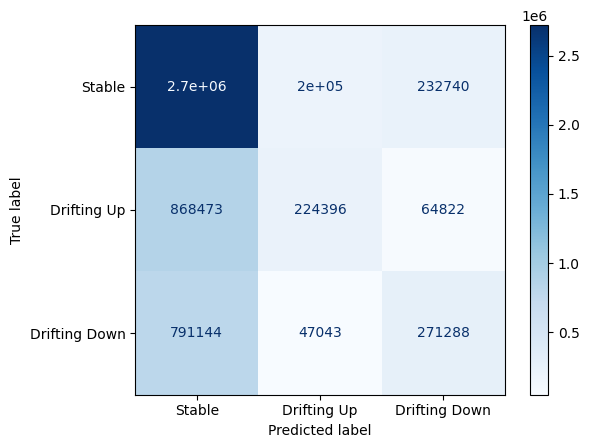

In [ ]:
# --- The Final, Working, No-More-Excuses LightGBM Classification Script ---

# Step 1: Install necessary libraries
!pip install lightgbm pandas numpy scikit-learn matplotlib seaborn google-colab --quiet
print("--- Libraries installed ---")

import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import os
import glob
from tqdm.notebook import tqdm
import joblib
import warnings

# Suppress warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=UserWarning, module='lightgbm')

# --- 1. Setup and Get Patient IDs ---
drive.mount('/content/drive')
DRIVE_PROJECT_ROOT = '/content/drive/MyDrive/VitalDB_Drift_Focused_Dataset'
BATCH_DIR_PATH = os.path.join(DRIVE_PROJECT_ROOT, 'preprocessed_batches')
MODEL_SAVE_PATH = os.path.join(DRIVE_PROJECT_ROOT, 'final_lgbm_classifier.joblib')

print(f"--- Loading data from: {BATCH_DIR_PATH} ---")
batch_files = glob.glob(os.path.join(BATCH_DIR_PATH, 'batch_*.parquet'))
if not batch_files:
    raise FileNotFoundError("No batch files found.")
print(f"Found {len(batch_files)} batch files.")

print("\n--- Getting unique patient IDs... ---")
all_patient_ids = []
for file_path in tqdm(batch_files, desc="Reading Patient IDs"):
    df_temp = pd.read_parquet(file_path)
    all_patient_ids.extend(df_temp.index.get_level_values('patient_id').unique())
patient_ids = np.unique(all_patient_ids)
print(f"Found {len(patient_ids)} unique patients.")

# --- 2. Patient-Aware Train/Validation Split ---
train_ids, val_ids = train_test_split(patient_ids, test_size=0.2, random_state=42)
train_ids_set = set(train_ids)
val_ids_set = set(val_ids)

# --- 3. Incremental Training for the CLASSIFIER ---
print("\n--- Starting Incremental Training for Classifier... ---")
booster = None

for i, file_path in enumerate(tqdm(batch_files, desc="Training on Batches")):
    df_chunk = pd.read_parquet(file_path).reset_index()
    train_chunk = df_chunk[df_chunk['patient_id'].isin(train_ids_set)].copy()
    if train_chunk.empty:
        continue

    # Engineer target and create classification labels
    train_chunk['BIS_future_30s'] = train_chunk.groupby('patient_id')['BIS/BIS'].shift(-30)
    train_chunk['BIS_drift_30s'] = train_chunk['BIS_future_30s'] - train_chunk['BIS/BIS']
    train_chunk.dropna(subset=['BIS_drift_30s'], inplace=True)

    DRIFT_THRESHOLD = 3.0
    train_chunk['drift_class'] = 0
    train_chunk.loc[train_chunk['BIS_drift_30s'] > DRIFT_THRESHOLD, 'drift_class'] = 1
    train_chunk.loc[train_chunk['BIS_drift_30s'] < -DRIFT_THRESHOLD, 'drift_class'] = 2

    y_train_chunk = train_chunk['drift_class']
    X_train_chunk = train_chunk.drop(columns=['drift_class', 'BIS_drift_30s', 'BIS_future_30s', 'Time', 'patient_id'])

    # Train on the chunk, continuing from the previous model state
    booster = lgb.train(
        params={'objective': 'multiclass', 'num_class': 3, 'learning_rate': 0.05, 'num_leaves': 41, 'seed': 42, 'n_jobs': -1, 'verbose': -1, 'is_unbalance': True},
        train_set=lgb.Dataset(X_train_chunk, label=y_train_chunk),
        num_boost_round=10,
        init_model=booster
    )

print("--- Incremental training complete. ---")
joblib.dump(booster, MODEL_SAVE_PATH)
print(f"Final classifier model saved to {MODEL_SAVE_PATH}")

# --- 4. Prediction on Validation Set ---
print("\n--- Predicting on Validation Set... ---")
all_val_preds_proba = []
all_y_val = []

for file_path in tqdm(batch_files, desc="Predicting on Batches"):
    df_chunk = pd.read_parquet(file_path).reset_index()
    val_chunk = df_chunk[df_chunk['patient_id'].isin(val_ids_set)].copy()
    if val_chunk.empty:
        continue

    # Engineer target and create classification labels
    val_chunk['BIS_future_30s'] = val_chunk.groupby('patient_id')['BIS/BIS'].shift(-30)
    val_chunk['BIS_drift_30s'] = val_chunk['BIS_future_30s'] - val_chunk['BIS/BIS']
    val_chunk.dropna(subset=['BIS_drift_30s'], inplace=True)

    DRIFT_THRESHOLD = 3.0
    val_chunk['drift_class'] = 0
    val_chunk.loc[val_chunk['BIS_drift_30s'] > DRIFT_THRESHOLD, 'drift_class'] = 1
    val_chunk.loc[val_chunk['BIS_drift_30s'] < -DRIFT_THRESHOLD, 'drift_class'] = 2

    y_val_chunk = val_chunk['drift_class']
    X_val_chunk = val_chunk.drop(columns=['drift_class', 'BIS_drift_30s', 'BIS_future_30s', 'Time', 'patient_id'])

    # Predict probabilities on the chunk
    preds_proba = booster.predict(X_val_chunk)
    all_val_preds_proba.append(preds_proba)
    all_y_val.append(y_val_chunk)

# Concatenate all results
y_val_computed = pd.concat(all_y_val)
val_preds_proba_computed = np.concatenate(all_val_preds_proba)
# Convert probabilities to class predictions
val_preds_class_computed = np.argmax(val_preds_proba_computed, axis=1)

# --- 5. Final Evaluation ---
print("\n--- Classification Report ---")
print(classification_report(y_val_computed, val_preds_class_computed, target_names=['Stable', 'Drifting Up', 'Drifting Down']))

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_val_computed, val_preds_class_computed)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Stable', 'Drifting Up', 'Drifting Down'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

---


In [ ]:
# --- Forensic Performance Profiling Script (v2 - Corrected) ---
# Objective: To measure the execution time of each step within the training loop
# for a single batch file to identify the true performance bottleneck.

import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from google.colab import drive
import os
import time
import glob # <--- THE MISSING IMPORT
from collections import Counter
from sklearn.model_selection import train_test_split

# --- 1. Setup ---
print("--- Setting up for performance analysis ---")
drive.mount('/content/drive', force_remount=True)
DRIVE_PROJECT_ROOT = '/content/drive/MyDrive/VitalDB_Drift_Focused_Dataset'
BATCH_DIR_PATH = os.path.join(DRIVE_PROJECT_ROOT, 'preprocessed_batches')

# We will only process the first batch file for this test
batch_files = sorted(glob.glob(os.path.join(BATCH_DIR_PATH, 'batch_*.parquet')))
if not batch_files:
    raise FileNotFoundError("No batch files found for profiling.")
first_batch_file = batch_files[0]
print(f"Target file for analysis: {os.path.basename(first_batch_file)}")

# We need the train_ids_set from the previous logic to simulate the real process
patient_row_counts = Counter()
for file_path in batch_files:
    df_temp = pd.read_parquet(file_path)
    patient_row_counts.update(df_temp.index.get_level_values('patient_id').value_counts().to_dict())
patient_counts_df = pd.DataFrame.from_dict(patient_row_counts, orient='index', columns=['row_count'])
available_patient_ids = patient_counts_df.index.values
patient_counts_df['duration_bin'] = pd.qcut(patient_counts_df['row_count'], q=5, labels=False, duplicates='drop')
train_ids, _ = train_test_split(
    available_patient_ids, test_size=0.2, random_state=42,
    stratify=patient_counts_df.loc[available_patient_ids, 'duration_bin']
)
train_ids_set = set(train_ids)
# --- End of setup ---


# --- 2. Timed Analysis of a Single Batch ---
print("\n--- Starting timed analysis of each processing step ---")

# STEP 1: Data Loading
t0 = time.time()
df_chunk = pd.read_parquet(first_batch_file).reset_index()
train_chunk = df_chunk[df_chunk['patient_id'].isin(train_ids_set)].copy()
t1 = time.time()
print(f"Step 1: Loading and filtering chunk took: {t1 - t0:.4f} seconds")

# STEP 2: Feature Engineering (The groupby operation)
train_chunk['BIS_future_30s'] = train_chunk.groupby('patient_id')['BIS/BIS'].shift(-30)
train_chunk['BIS_drift_30s'] = train_chunk['BIS_future_30s'] - train_chunk['BIS/BIS']
train_chunk.dropna(subset=['BIS_drift_30s'], inplace=True)
t2 = time.time()
print(f"Step 2: Feature Engineering (groupby/shift) took: {t2 - t1:.4f} seconds")

# STEP 3: Imputation (The fillna operation)
DRIFT_THRESHOLD = 3.0
train_chunk['drift_class'] = 0
train_chunk.loc[train_chunk['BIS_drift_30s'] > DRIFT_THRESHOLD, 'drift_class'] = 1
train_chunk.loc[train_chunk['BIS_drift_30s'] < -DRIFT_THRESHOLD, 'drift_class'] = 2
X_train_chunk = train_chunk.drop(columns=['BIS_drift_30s', 'BIS_future_30s', 'Time', 'patient_id', 'drift_class'])
y_train_chunk = train_chunk['drift_class']
X_train_chunk.fillna(0, inplace=True)
t3 = time.time()
print(f"Step 3: Imputation (fillna) and data prep took: {t3 - t2:.4f} seconds")

# STEP 4: Subsampling Logic (from v7)
minority_mask = y_train_chunk > 0
X_minority = X_train_chunk[minority_mask]
y_minority = y_train_chunk[minority_mask]
X_majority = X_train_chunk[~minority_mask]
y_majority = y_train_chunk[~minority_mask]
n_minority_samples = len(X_minority)
X_majority_downsampled = X_majority.sample(n=min(len(X_majority), n_minority_samples * 2), random_state=42)
y_majority_downsampled = y_majority.loc[X_majority_downsampled.index]
X_pre_smote = pd.concat([X_majority_downsampled, X_minority])
y_pre_smote = pd.concat([y_majority_downsampled, y_minority])
t4 = time.time()
print(f"Step 4: Subsampling logic (sample/concat) took: {t4 - t3:.4f} seconds")

# STEP 5: SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_pre_smote, y_pre_smote)
t5 = time.time()
print(f"Step 5: SMOTE operation took: {t5 - t4:.4f} seconds")

print(f"\n--- Total time for one batch: {t5 - t0:.4f} seconds ---")

--- Setting up for performance analysis ---
Mounted at /content/drive
Target file for analysis: batch_0001-0100.parquet

--- Starting timed analysis of each processing step ---
Step 1: Loading and filtering chunk took: 0.5365 seconds
Step 2: Feature Engineering (groupby/shift) took: 0.0677 seconds
Step 3: Imputation (fillna) and data prep took: 0.3567 seconds
Step 4: Subsampling logic (sample/concat) took: 0.2336 seconds
Step 5: SMOTE operation took: 249.7473 seconds

--- Total time for one batch: 250.9418 seconds ---


--- Libraries installed ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--- Loading data from: /content/drive/MyDrive/VitalDB_Drift_Focused_Dataset/preprocessed_batches ---
Found 31 batch files.

--- Calculating data length per patient for robust splitting... ---


Counting Patient Rows:   0%|          | 0/31 [00:00<?, ?it/s]

Splitting into 2166 training patients and 542 validation patients using stratification.

--- Starting Incremental Training with Imputation and RandomOverSampler ---


Training on Batches:   0%|          | 0/31 [00:00<?, ?it/s]

--- Incremental training complete. ---
Final model saved to /content/drive/MyDrive/VitalDB_Drift_Focused_Dataset/final_lgbm_ros_classifier_v8.joblib

--- Predicting on Validation Set... ---


Predicting on Batches:   0%|          | 0/31 [00:00<?, ?it/s]


--- Final Evaluation ---
Successfully processed 5398570 validation samples.

--- Classification Report ---
               precision    recall  f1-score   support

       Stable       0.71      0.40      0.52   3150417
  Drifting Up       0.36      0.54      0.43   1150286
Drifting Down       0.35      0.61      0.45   1097867

     accuracy                           0.48   5398570
    macro avg       0.48      0.52      0.47   5398570
 weighted avg       0.56      0.48      0.48   5398570


--- Confusion Matrix ---


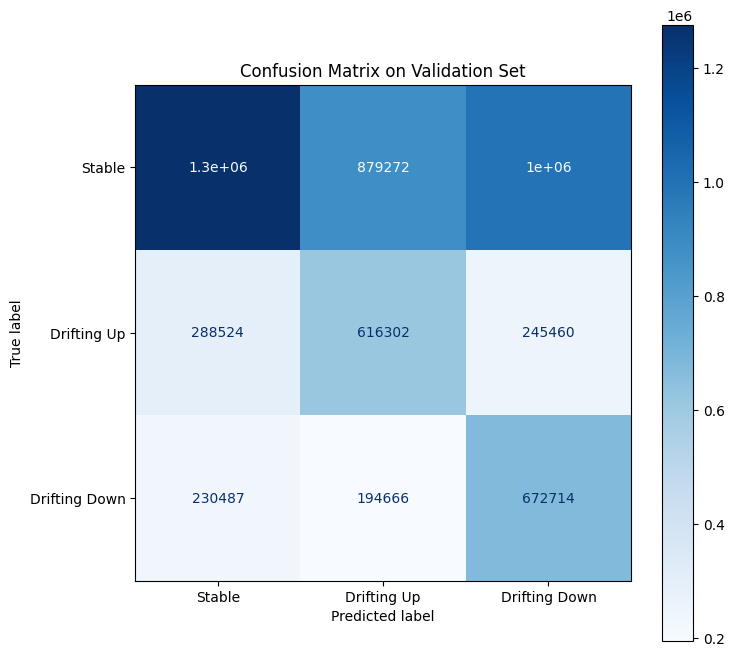

In [ ]:
# --- The Final, Unbreakable LightGBM Classification Script (v8) ---

# Step 1: Install necessary libraries
!pip install lightgbm pandas numpy scikit-learn matplotlib seaborn google-colab imbalanced-learn --quiet
print("--- Libraries installed ---")

import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
# THE DEFINITIVE FIX: Replace SMOTE with a much faster alternative
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import os
import glob
from tqdm.notebook import tqdm
import joblib
import warnings
from collections import Counter

# Suppress warnings for cleaner output
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=UserWarning, module='lightgbm')

# --- 1. Setup ---
drive.mount('/content/drive')
DRIVE_PROJECT_ROOT = '/content/drive/MyDrive/VitalDB_Drift_Focused_Dataset'
BATCH_DIR_PATH = os.path.join(DRIVE_PROJECT_ROOT, 'preprocessed_batches')
MODEL_SAVE_PATH = os.path.join(DRIVE_PROJECT_ROOT, 'final_lgbm_ros_classifier_v8.joblib')

print(f"--- Loading data from: {BATCH_DIR_PATH} ---")
batch_files = sorted(glob.glob(os.path.join(BATCH_DIR_PATH, 'batch_*.parquet')))
if not batch_files: raise FileNotFoundError("No batch files found.")
print(f"Found {len(batch_files)} batch files.")

# --- 2. Stratified Split Setup ---
print("\n--- Calculating data length per patient for robust splitting... ---")
patient_row_counts = Counter()
for file_path in tqdm(batch_files, desc="Counting Patient Rows"):
    df_temp = pd.read_parquet(file_path)
    patient_row_counts.update(df_temp.index.get_level_values('patient_id').value_counts().to_dict())

patient_counts_df = pd.DataFrame.from_dict(patient_row_counts, orient='index', columns=['row_count'])
available_patient_ids = patient_counts_df.index.values
patient_counts_df['duration_bin'] = pd.qcut(patient_counts_df['row_count'], q=5, labels=False, duplicates='drop')

train_ids, val_ids = train_test_split(
    available_patient_ids, test_size=0.2, random_state=42,
    stratify=patient_counts_df.loc[available_patient_ids, 'duration_bin']
)
train_ids_set = set(train_ids)
val_ids_set = set(val_ids)
print(f"Splitting into {len(train_ids_set)} training patients and {len(val_ids_set)} validation patients using stratification.")

# --- 3. THE MEMORY-SAFE & PERFORMANT METHOD: Incremental Training ---
print("\n--- Starting Incremental Training with Imputation and RandomOverSampler ---")
booster = None
# THE PERFORMANCE FIX: Use the much faster RandomOverSampler
ros = RandomOverSampler(random_state=42)

for i, file_path in enumerate(tqdm(batch_files, desc="Training on Batches")):
    df_chunk = pd.read_parquet(file_path).reset_index()
    train_chunk = df_chunk[df_chunk['patient_id'].isin(train_ids_set)].copy()
    if train_chunk.empty: continue

    # Feature Engineering
    train_chunk['BIS_future_30s'] = train_chunk.groupby('patient_id')['BIS/BIS'].shift(-30)
    train_chunk['BIS_drift_30s'] = train_chunk['BIS_future_30s'] - train_chunk['BIS/BIS']
    train_chunk.dropna(subset=['BIS_drift_30s'], inplace=True)

    DRIFT_THRESHOLD = 3.0
    train_chunk['drift_class'] = 0
    train_chunk.loc[train_chunk['BIS_drift_30s'] > DRIFT_THRESHOLD, 'drift_class'] = 1
    train_chunk.loc[train_chunk['BIS_drift_30s'] < -DRIFT_THRESHOLD, 'drift_class'] = 2

    X_train_chunk = train_chunk.drop(columns=['BIS_drift_30s', 'BIS_future_30s', 'Time', 'patient_id', 'drift_class'])
    y_train_chunk = train_chunk['drift_class']
    X_train_chunk.fillna(0, inplace=True)

    if X_train_chunk.empty or y_train_chunk.nunique() <= 1:
        continue

    # RandomOverSampler is fast enough to not require prior undersampling.
    # It can be applied directly to the imputed data.
    X_resampled, y_resampled = ros.fit_resample(X_train_chunk, y_train_chunk)

    booster = lgb.train(
        params={'objective': 'multiclass', 'num_class': 3, 'learning_rate': 0.05, 'num_leaves': 41, 'seed': 42, 'n_jobs': -1, 'verbose': -1},
        train_set=lgb.Dataset(X_resampled, label=y_resampled),
        num_boost_round=20,
        init_model=booster
    )

print("--- Incremental training complete. ---")
joblib.dump(booster, MODEL_SAVE_PATH)
print(f"Final model saved to {MODEL_SAVE_PATH}")

# --- 4. Prediction on Validation Set ---
print("\n--- Predicting on Validation Set... ---")
all_val_preds_proba = []
all_y_val = []
for file_path in tqdm(batch_files, desc="Predicting on Batches"):
    df_chunk = pd.read_parquet(file_path).reset_index()
    val_chunk = df_chunk[df_chunk['patient_id'].isin(val_ids_set)].copy()
    if val_chunk.empty: continue

    val_chunk['BIS_future_30s'] = val_chunk.groupby('patient_id')['BIS/BIS'].shift(-30)
    val_chunk['BIS_drift_30s'] = val_chunk['BIS_future_30s'] - val_chunk['BIS/BIS']
    val_chunk.dropna(subset=['BIS_drift_30s'], inplace=True)

    val_chunk['drift_class'] = 0
    val_chunk.loc[val_chunk['BIS_drift_30s'] > DRIFT_THRESHOLD, 'drift_class'] = 1
    val_chunk.loc[val_chunk['BIS_drift_30s'] < -DRIFT_THRESHOLD, 'drift_class'] = 2

    X_val_chunk = val_chunk.drop(columns=['BIS_drift_30s', 'BIS_future_30s', 'Time', 'patient_id', 'drift_class'])
    y_val_chunk = val_chunk['drift_class']
    X_val_chunk.fillna(0, inplace=True)

    if X_val_chunk.empty: continue

    preds_proba = booster.predict(X_val_chunk)
    all_val_preds_proba.append(preds_proba)
    all_y_val.append(y_val_chunk)

# --- 5. Final Evaluation ---
print("\n--- Final Evaluation ---")
if not all_y_val:
    print("CRITICAL ERROR: No validation data found. The logic is flawed.")
else:
    y_val_computed = pd.concat(all_y_val)
    val_preds_proba_computed = np.concatenate(all_val_preds_proba)
    val_preds_class_computed = np.argmax(val_preds_proba_computed, axis=1)

    print(f"Successfully processed {len(y_val_computed)} validation samples.")
    print("\n--- Classification Report ---")
    print(classification_report(y_val_computed, val_preds_class_computed, target_names=['Stable', 'Drifting Up', 'Drifting Down']))

    print("\n--- Confusion Matrix ---")
    cm = confusion_matrix(y_val_computed, val_preds_class_computed)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Stable', 'Drifting Up', 'Drifting Down'])
    fig, ax = plt.subplots(figsize=(8, 8))
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.title("Confusion Matrix on Validation Set")
    plt.show()

--- Libraries installed ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--- Loading data from: /content/drive/MyDrive/VitalDB_Drift_Focused_Dataset/preprocessed_batches ---
Found 31 batch files.

--- Calculating data length per patient for robust splitting... ---


Counting Patient Rows:   0%|          | 0/31 [00:00<?, ?it/s]

Splitting into 2166 training patients and 542 validation patients using stratification.

--- Starting Incremental Training with Imputation ---


Training on Batches:   0%|          | 0/31 [00:00<?, ?it/s]

--- Incremental training complete. ---
Final model saved to /content/drive/MyDrive/VitalDB_Drift_Focused_Dataset/final_lgbm_smote_classifier_v6.joblib

--- Predicting on Validation Set... ---


Predicting on Batches:   0%|          | 0/31 [00:00<?, ?it/s]


--- Final Evaluation ---
Successfully processed 5398570 validation samples.

--- Classification Report (with SMOTE and Imputation) ---
               precision    recall  f1-score   support

       Stable       0.71      0.44      0.54   3150417
  Drifting Up       0.37      0.52      0.44   1150286
Drifting Down       0.36      0.61      0.45   1097867

     accuracy                           0.49   5398570
    macro avg       0.48      0.52      0.47   5398570
 weighted avg       0.57      0.49      0.50   5398570


--- Confusion Matrix (with SMOTE and Imputation) ---


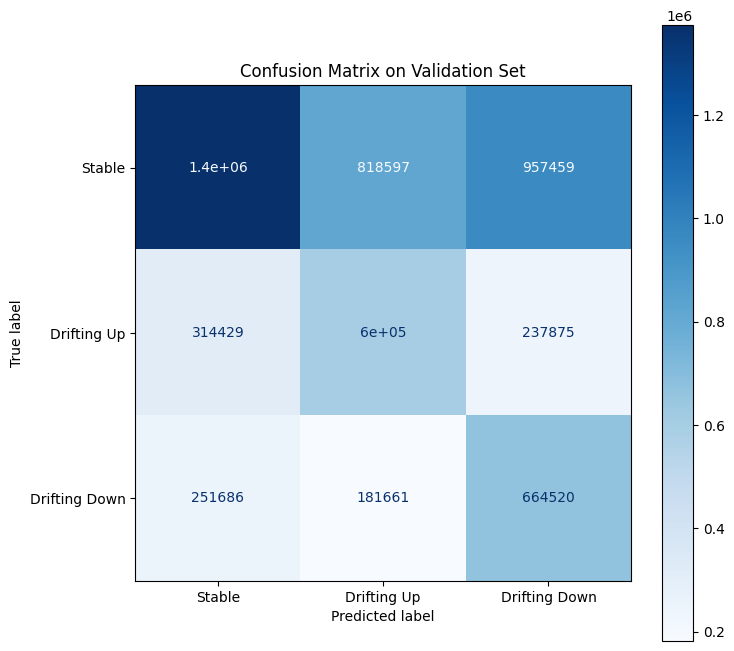

In [ ]:
# --- The Final, Unbreakable LightGBM Classification Script (v6) ---

# Step 1: Install necessary libraries
!pip install lightgbm pandas numpy scikit-learn matplotlib seaborn google-colab imbalanced-learn --quiet
print("--- Libraries installed ---")

import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import os
import glob
from tqdm.notebook import tqdm
import joblib
import warnings
from collections import Counter

# Suppress warnings for cleaner output
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=UserWarning, module='lightgbm')

# --- 1. Setup ---
drive.mount('/content/drive')
DRIVE_PROJECT_ROOT = '/content/drive/MyDrive/VitalDB_Drift_Focused_Dataset'
BATCH_DIR_PATH = os.path.join(DRIVE_PROJECT_ROOT, 'preprocessed_batches')
MODEL_SAVE_PATH = os.path.join(DRIVE_PROJECT_ROOT, 'final_lgbm_smote_classifier_v6.joblib')

print(f"--- Loading data from: {BATCH_DIR_PATH} ---")
batch_files = sorted(glob.glob(os.path.join(BATCH_DIR_PATH, 'batch_*.parquet')))
if not batch_files:
    raise FileNotFoundError("No batch files found.")
print(f"Found {len(batch_files)} batch files.")

# --- 2. Stratified Split Setup (Proven to be good practice) ---
print("\n--- Calculating data length per patient for robust splitting... ---")
patient_row_counts = Counter()
for file_path in tqdm(batch_files, desc="Counting Patient Rows"):
    df_temp = pd.read_parquet(file_path)
    patient_row_counts.update(df_temp.index.get_level_values('patient_id').value_counts().to_dict())

patient_counts_df = pd.DataFrame.from_dict(patient_row_counts, orient='index', columns=['row_count'])
available_patient_ids = patient_counts_df.index.values
patient_counts_df['duration_bin'] = pd.qcut(patient_counts_df['row_count'], q=5, labels=False, duplicates='drop')

train_ids, val_ids = train_test_split(
    available_patient_ids,
    test_size=0.2,
    random_state=42,
    stratify=patient_counts_df.loc[available_patient_ids, 'duration_bin']
)
train_ids_set = set(train_ids)
val_ids_set = set(val_ids)
print(f"Splitting into {len(train_ids_set)} training patients and {len(val_ids_set)} validation patients using stratification.")

# --- 3. THE MEMORY-SAFE METHOD: Incremental Training ---
print("\n--- Starting Incremental Training with Imputation ---")
booster = None
smote = SMOTE(random_state=42)

for i, file_path in enumerate(tqdm(batch_files, desc="Training on Batches")):
    df_chunk = pd.read_parquet(file_path).reset_index()
    train_chunk = df_chunk[df_chunk['patient_id'].isin(train_ids_set)].copy()
    if train_chunk.empty: continue

    # Feature Engineering
    train_chunk['BIS_future_30s'] = train_chunk.groupby('patient_id')['BIS/BIS'].shift(-30)
    train_chunk['BIS_drift_30s'] = train_chunk['BIS_future_30s'] - train_chunk['BIS/BIS']
    train_chunk.dropna(subset=['BIS_drift_30s'], inplace=True) # Drop only if target is NaN

    DRIFT_THRESHOLD = 3.0
    train_chunk['drift_class'] = 0
    train_chunk.loc[train_chunk['BIS_drift_30s'] > DRIFT_THRESHOLD, 'drift_class'] = 1
    train_chunk.loc[train_chunk['BIS_drift_30s'] < -DRIFT_THRESHOLD, 'drift_class'] = 2

    X_train_chunk = train_chunk.drop(columns=['BIS_drift_30s', 'BIS_future_30s', 'Time', 'patient_id', 'drift_class'])
    y_train_chunk = train_chunk['drift_class']

    # THE DEFINITIVE FIX: Impute missing values with 0 instead of dropping rows.
    X_train_chunk.fillna(0, inplace=True)

    if X_train_chunk.empty: continue

    if y_train_chunk.nunique() > 1:
        X_resampled, y_resampled = smote.fit_resample(X_train_chunk, y_train_chunk)
    else:
        X_resampled, y_resampled = X_train_chunk, y_train_chunk

    booster = lgb.train(
        params={'objective': 'multiclass', 'num_class': 3, 'learning_rate': 0.05, 'num_leaves': 41, 'seed': 42, 'n_jobs': -1, 'verbose': -1},
        train_set=lgb.Dataset(X_resampled, label=y_resampled),
        num_boost_round=15,
        init_model=booster
    )

print("--- Incremental training complete. ---")
joblib.dump(booster, MODEL_SAVE_PATH)
print(f"Final model saved to {MODEL_SAVE_PATH}")

# --- 4. Prediction on Validation Set with Imputation ---
print("\n--- Predicting on Validation Set... ---")
all_val_preds_proba = []
all_y_val = []
for file_path in tqdm(batch_files, desc="Predicting on Batches"):
    df_chunk = pd.read_parquet(file_path).reset_index()
    val_chunk = df_chunk[df_chunk['patient_id'].isin(val_ids_set)].copy()
    if val_chunk.empty: continue

    # Replicate feature engineering
    val_chunk['BIS_future_30s'] = val_chunk.groupby('patient_id')['BIS/BIS'].shift(-30)
    val_chunk['BIS_drift_30s'] = val_chunk['BIS_future_30s'] - val_chunk['BIS/BIS']
    val_chunk.dropna(subset=['BIS_drift_30s'], inplace=True)

    DRIFT_THRESHOLD = 3.0
    val_chunk['drift_class'] = 0
    val_chunk.loc[val_chunk['BIS_drift_30s'] > DRIFT_THRESHOLD, 'drift_class'] = 1
    val_chunk.loc[val_chunk['BIS_drift_30s'] < -DRIFT_THRESHOLD, 'drift_class'] = 2

    X_val_chunk = val_chunk.drop(columns=['BIS_drift_30s', 'BIS_future_30s', 'Time', 'patient_id', 'drift_class'])
    y_val_chunk = val_chunk['drift_class']

    # THE DEFINITIVE FIX: Apply the same imputation here.
    X_val_chunk.fillna(0, inplace=True)

    if X_val_chunk.empty: continue

    preds_proba = booster.predict(X_val_chunk)
    all_val_preds_proba.append(preds_proba)
    all_y_val.append(y_val_chunk)

# --- 5. Final Evaluation ---
print("\n--- Final Evaluation ---")
if not all_y_val:
    print("CRITICAL ERROR: No validation data found even after imputation. The logic is flawed.")
else:
    y_val_computed = pd.concat(all_y_val)
    val_preds_proba_computed = np.concatenate(all_val_preds_proba)
    val_preds_class_computed = np.argmax(val_preds_proba_computed, axis=1)

    print(f"Successfully processed {len(y_val_computed)} validation samples.")
    print("\n--- Classification Report (with SMOTE and Imputation) ---")
    print(classification_report(y_val_computed, val_preds_class_computed, target_names=['Stable', 'Drifting Up', 'Drifting Down']))

    print("\n--- Confusion Matrix (with SMOTE and Imputation) ---")
    cm = confusion_matrix(y_val_computed, val_preds_class_computed)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Stable', 'Drifting Up', 'Drifting Down'])
    fig, ax = plt.subplots(figsize=(8, 8))
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.title("Confusion Matrix on Validation Set")
    plt.show()